## Text Summarization using a seq2seq with attention model on Pytorch

**DESCRIBE WHAT IS THE ALGO.**

Link:
https://www.kaggle.com/rahuldshetty/text-summarization-in-pytorch



In [50]:
import pandas as pd
import numpy as np
import os
import time
import math
import random

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.switch_backend('agg')
#import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline

import nltk
nltk.download('punkt')

from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.model_selection import train_test_split
#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences

#Import library to calculate the evaluation metric
#from rouge import FilesRouge, Rouge


[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Defining global variables

In [2]:
data_path='../data'
glove_file = 'glove.6B.100d.txt'
glove_filename = os.path.join(data_path, glove_file)
#Define some especial tokens for our vocabulary
SOS_token = 0
EOS_token = 1


#### Helper Functions 

In [3]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

### Loading the data

In [4]:
# Run only when new datafiles have been stored in GS
#%%bash
#gsutil cp gs://mlend_bucket/data/news_summary/news_summary_more.csv ../data/

In [4]:
summary = pd.read_csv('MLE_Capstone_Text_Summarization/data/news_summary.csv', encoding='iso-8859-1')
summary.head(5)

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [5]:
#Drop duplicate rows
summary.drop_duplicates(subset=["ctext"],inplace=True)
#Drop rows with null values in the text variable
summary.dropna(inplace=True)
summary.reset_index(drop=True,inplace=True)
# we are using the text variable as the summary and the ctext as the source text
dataset = summary[['text','ctext']].copy()
dataset.columns = ['summary','text']
dataset.head(5)

,summary,text
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


### Data preprocess and cleanings

Lets dive into the dataset to verify come cleanings we need to apply to our dataset.
- Expand contractions
- Puntuaction separation
- Remove multispaces


In [6]:
import re

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", 
                       "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                       "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", 
                       "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", 
                       "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                       "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", 
                       "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                       "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", 
                       "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                       "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
                       "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", 
                       "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                       "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", 
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is",
                       "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
                       "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                       "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", 
                       "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  
                       "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", 
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                       "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", 
                       "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                       "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
                       "y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", 
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

punct = "/-'.,?!#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

def expand_contractions(text):
    ''' Expand the contractions (some well-known of them) in a text'''
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")])
    return text

def remove_mult_spaces(text):
    re_mult_space = re.compile(r"  *") # replace multiple spaces with just one
    return re_mult_space.sub(r' ', text)

def sep_punctuation(text, punct):
# Separate punctuation with whitespaces
    for p in punct:
        text = text.replace(p, f'{p} ')

    return text

def remove_CTL(text):
    url = re.compile(r'\n')
    return url.sub(r' ',text)

def clean_text(text):
    new_text=text
    new_text=new_text.apply(lambda x : expand_contractions(x))
    new_text=new_text.apply(lambda x : sep_punctuation(x,punct))
    new_text=new_text.apply(lambda x : remove_mult_spaces(x))
    new_text=new_text.apply(lambda x : remove_CTL(x))
    return new_text


### Text cleaning and preprocess

In [7]:
dataset['text']=clean_text(dataset['text'])
dataset['summary']=clean_text(dataset['summary'])

In [ ]:
#Split every document into a list of sentences
dataset['list_sentences'] = split_sentences(dataset['text'].values)
dataset['list_summary'] = split_sentences(dataset['summary'].values)

### Split the data in training and validation sets

In [54]:
train_data, val_data, train_target, val_target = train_test_split(dataset['list_sentences'].values, dataset['list_summary'].values, 
                                                                  test_size=0.15, random_state=0)

In [55]:
print('Length Train Text: ',len(train_data), ' Length Train Target: ', len(train_target))
print('Length Val Text: ',len(val_data), ' Length Train Target: ', len(val_target))

Length Train Text:  3689  Length Train Target:  3689
Length Val Text:  652  Length Train Target:  652


#### Create the vocabulary for our problem

In [8]:
# Function to tokenize or split a text in sentences
def split_sentences(documents):
    """
    Splits the documents into individual sentences.
    Input:
       - documents: list of string to split into sentences
    Output:
        - list of list of strings (sentence)
    """
    docs_sentences=[]
    n_docs = len(documents)
    for i in range(n_docs):
        text = documents[i]
        #print(email)
        sentences = sent_tokenize(text)
        #print(sentences)
        for j in reversed(range(len(sentences))):
            sent = sentences[j]
            sentences[j] = sent.strip()
            if sent == '':
                sentences.pop(j)
        docs_sentences.append(sentences)
        
    return docs_sentences

class Vocabulary:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
    def fit(self, data):
        ''' data: list of list of string sentence
        '''
        #tokens = [sentence.lower().split() for doc in data for sentence in doc]
        tokens= [word_tokenize(sentence.lower()) for doc in data for sentence in doc]
        tokens= [token for sentence in tokens for token in sentence]

        for word in tokens:
            self.addWord(word)
        
        self.addWord('<UNK>')
        
    def transform(self, data, eos_token=True):
    # determine the dimensionality of vectors
    
        errors=0
        docs2int=[]
        for doc in data:
            doc2int=[]
            for sentence in doc:
                tokens = word_tokenize(sentence.lower())
                #vecs=[]
                for word in tokens:
                    try:
                      # throws KeyError if word not found
                        vec = self.word2index[word]
                        doc2int.append(vec)
                    except KeyError:
                        errors +=1
      
                #if len(vecs) > 0:
                #    sent2int.append(vecs)
            if len(doc2int) > 0:
                if eos_token:
                    doc2int.append(EOS_token)
                    
                docs2int.append(doc2int)
    
        return docs2int


Lets create the vocabulary for the documents data and the summaries

In [32]:
#Load the Glove embeddings
#data= dataset['list_sentences'].values
#data_sum= dataset['list_summary'].values
#data= dataset['list_sentences'].values
#data_sum= dataset['list_summary'].values

#print(data)
vocab_text = Vocabulary('text')
vocab_text.fit(train_data)
#print(len(vocab_text.word2index))
#vocab_text.fit(data_sum)
#print(len(vocab_text.word2index))

vocab_summary = Vocabulary('summary')
vocab_summary.fit(train_target)

In [33]:
len(vocab_summary.word2index),len(vocab_text.word2index)

(20945, 55983)

#### Check the vocabulary sizes

In [67]:
tokens=[word_tokenize(sentence.lower()) for doc in data_sum for sentence in doc]
sum=0
for tok in tokens:
    sum+=len(tok)
    
len(vocab_summary.word2index),sum

(224, 367)

In [68]:
#sum(vocab_text.word2count.values())
d=list(vocab_summary.word2count.values())
#print(d)
da=np.array(d)
np.sum(da)
#d

368

#### Create the input and output indexes

In [34]:
#Load the Glove embeddings
#data = dataset['list_sentences'].values
#data_sum= dataset['list_summary'].values
#data_sum= dataset['list_summary'].values[:1]

inputs=vocab_text.transform(train_data)
outputs=vocab_summary.transform(train_target)

In [135]:
max([len(ip) for ip in inputs])

14352

#### Check the text transformed

In [108]:
tokens=[word_tokenize(sentence.lower()) for doc in data for sentence in doc]
sum=0
for tok in tokens:
    sum+=len(tok)
    
len(vocab_summary.word2index),sum

(20945, 1762613)

In [109]:
#inp=[tk for doc in data for tk in doc]
sum=0
for tok in inputs:
    sum+=len(tok)
    
len(vocab_summary.word2index),sum

(20945, 1762613)

## Define the Pytorch Seq2Seq Model

In [13]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
device

device(type='cpu')

#### Define the Encoder

In [15]:
# Class for an enconder instance
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### Define the Decoder

In [16]:
# Define a decoder instance
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [17]:
#Define a decoder with attention mechanism class
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=100):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [40]:

def trainStep(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, 
          teacher_forcing_ratio, criterion, max_length=100):
    
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    #print('Input Length: ',input_length)
    target_length = target_tensor.size(0)
    #print('Target Length: ',target_length)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
#            print('di:', str(di))
#            print('TargTensor: ',target_tensor.shape)
#            print('DecOutput: ',decoder_output.shape)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
#            print('di:', str(di))
#            print('TargTensor: ',target_tensor.shape)
#            print('DecOutput: ',decoder_output.shape)

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [41]:
def trainIters(inputs, targets, encoder, decoder, n_iters, print_every=1000, plot_every=100, 
               learning_rate=0.01, teacher_forcing_ratio=0.5, max_length=100):
    '''
    inputs: a list of tensors from the list of integer_token
    targets: a list of tensors from the list of integer_token
    '''
    print("Training....")
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    #training_pairs = [tensorsFromPair(random.choice(pairs))
    #                  for i in range(n_iters)]
    input_training = random.sample(inputs, n_iters)
    target_training = random.sample(targets, n_iters)
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        if iter% 1000 == 0:
            print(iter,"/",n_iters + 1)
        # If the length of the text in tokens is greater the max_length, skip it
        if len(input_training[iter-1]) > max_length:
            continue
        #training_pair = training_pairs[iter - 1]
        input_tensor = torch.tensor(input_training[iter-1], dtype=torch.long, device=device).view(-1, 1)
        #print('Input Shape: ',input_tensor.shape)
        
        #input_training[iter - 1]
        target_tensor = torch.tensor(target_training[iter-1], dtype=torch.long, device=device).view(-1, 1)
        #print('Output Shape: ',target_tensor.shape)

        #targets[iter - 1]

        loss = trainStep(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, 
                         teacher_forcing_ratio, criterion, max_length)

        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


### TRain the model

Training....
2m 13s (- 20m 2s) (100 10%) 8.0722
4m 30s (- 18m 2s) (200 20%) 7.3767
6m 32s (- 15m 16s) (300 30%) 6.8954
8m 37s (- 12m 55s) (400 40%) 6.3201
10m 34s (- 10m 34s) (500 50%) 5.8797
12m 37s (- 8m 25s) (600 60%) 5.7803
14m 59s (- 6m 25s) (700 70%) 5.7883
17m 9s (- 4m 17s) (800 80%) 5.6219
19m 11s (- 2m 7s) (900 90%) 5.8143
1000 / 1001
21m 26s (- 0m 0s) (1000 100%) 6.1243


<Figure size 432x288 with 0 Axes>

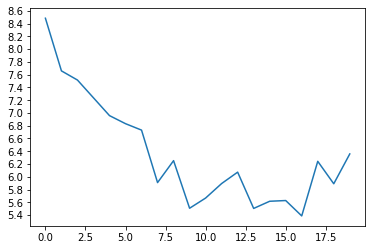

In [42]:
hidden_size = 50
encoder1 = EncoderRNN(vocab_text.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, vocab_summary.n_words, dropout_p=0.1, max_length=5000).to(device)

trainIters(inputs, outputs, encoder1, attn_decoder1, 1000,  print_every=100, plot_every=50, max_length=5000)

Now that the model is trained,it will be saved to disk

In [ ]:
torch.save(encoder1.state_dict(), './enc.w')
torch.save(attn_decoder1.state_dict(), './att.w')

### Prediction

In [56]:
def predict_summary(encoder, decoder, input, vocab_output, max_length=100):
    with torch.no_grad():
        input_tensor = torch.tensor(input, dtype=torch.long, device=device).view(-1, 1)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(vocab_output.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words      #, decoder_attentions[:di + 1]


In [57]:
#predict_summary(encoder, decoder, input, max_length=100)
dec_sent = predict_summary(encoder1, attn_decoder1, inputs[0], vocab_summary, max_length=5000)
print(dec_sent)
print(dec_attention)

['the', 'the', 'the', 'has', 'has', 'and', 'the', "'", 's', 'the', 'of', 'the', 'the', 'the', '.', 'the', 'the', 'the', 'the', '.', 'the', 'the', '.', 'the', 'the', 'the', '.', 'the', 'the', '.', 'the', 'the', '.', 'the', 'the', '.', 'the', '.', 'the', '.', 'the', '.', 'the', '.', 'the', 'the', '.', 'the', '.', 'the', 'the', '.', 'the', '.', 'the', '.', 'the', '.', 'the', '.', 'the', '.', 'the', '.', 'the', '.', 'the', '.', 'the', '.', 'the', '.', 'the', '.', 'the', '.', 'the', '.', 'the', '.', 'the', '.', 'the', '.', 'the', '.', 'the', '.', 'the', '.', 'the', '.', '.', 'the', '.', 'the', '.', 'the', '.', 'the', '.', 'the', '.', 'the', '.', 'the', '.', '.', 'the', '.', 'the', '.', 'the', '.', '.', 'the', '.', 'the', '.', 'the', '.', 'the', '.', 'the', '.', 'the', '.', '.', '<EOS>']
tensor([[2.2370e-04, 1.8803e-04, 6.0297e-04,  ..., 3.4757e-04, 8.7536e-05,
         9.8834e-05],
        [8.8325e-05, 1.8362e-04, 1.3592e-04,  ..., 2.8329e-04, 1.2433e-04,
         6.1018e-05],
        [1.15

Lets generate the predicted summaries for our vaildation dataset

In [ ]:
#Tranforme the text to the indexes in the vocabulary
inputs=vocab_text.transform(val_data)
outputs=vocab_summary.transform(val_target)

In [ ]:
len(inputs)

In [58]:
#Predict the summary for the vaildation dataset
#predicted_summaries = 
predicted_summaries = [' '.join(predict_summary(encoder1, attn_decoder1, inputs[0], vocab_summary, max_length=5000)) for input in inputs]

"the the the has has and the ' s ' s the of the the . the the the . the the the . the the the . the the . the . the . the the . the . the . the . the . the . the . the . the . the . the . the . the . the . the . the . the . the . the . the . the . the . . the . . the . . the . the . the . the . the . the . . the . . the . the . the . the . the . the . the . . the . . the . the . . the . the . the . . the . the . the . the . the . . <EOS>"